In [31]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
os.environ["MOSEKLM_LICENSE_FILE"] = '/home/seiji/mosek/mosek.lic'

import sys
sys.path.append("../src")

In [2]:
import numpy as np
from pydrake.all import (
    StartMeshcat,
    Simulator,
    DirectCollocation,
    Solve,
    PiecewisePolynomial
)
import matplotlib.pyplot as plt

In [3]:
from world import make_n_quadrotor_system
from util import DisableCollisionChecking
from stabilization import find_fixed_point_snopt, finite_horizon_lqr_stabilize_to_trajectory, add_controller_to_system
from planning import DifferentialFlatness


In [4]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [6]:
np.random.seed(0)

cable_length = 2
cable_hooke_K = 10
free_body_mass = 1
n_quadrotors = 3
quadrotor_input_limit = 3  # or None

min_quadrotor_distance = 1  # or None
min_cable_length = 2.1
controller_time_horizon = 10

In [7]:
diagram, plant = make_n_quadrotor_system(meshcat,
                                         n_quadrotors,
                                         cable_length,
                                         cable_hooke_K,
                                         free_body_mass)

In [8]:
quad_mass = 0.775
quad_inertia = np.diag([0.0015, 0.0025, 0.0035])
kF = 1.0
kM = 0.0245
arm_length = 0.15

diff_flat_output_backer = DifferentialFlatness(
    free_body_mass,
    cable_length,
    cable_hooke_K,
    kF,
    kM,
    arm_length,
    quad_mass,
    quad_inertia
)

In [8]:
# STRAIGHT LINE TRAJECTORY
mass_state_0 = np.zeros(3)
two_pi_over_three = 2.0 * np.pi / 3.0

quad_poses0 = free_body_mass * 9.81 / 3 / cable_hooke_K * np.array([[np.cos(0), np.sin(0), 1.0],
                                                                    [np.cos(two_pi_over_three),
                                                                     np.sin(two_pi_over_three), 1.0],
                                                                    [np.cos(2 * two_pi_over_three),
                                                                     np.sin(2 * two_pi_over_three), 1.0]])

mass_state_1 = np.array([0.0, 1.0, 0.0])
quad_poses1 = free_body_mass * 9.81 / 3 / cable_hooke_K * np.array([[np.cos(0), np.sin(0), 1.0],
                                                                    [np.cos(two_pi_over_three),
                                                                     np.sin(two_pi_over_three), 1.0],
                                                                    [np.cos(2 * two_pi_over_three),
                                                                     np.sin(2 * two_pi_over_three), 1.0]])
quad_poses1[:, 1] += 1


mass_output0, tension_output0, yaw_output0 = diff_flat_output_backer.state_to_output(mass_state_0, quad_poses0, np.zeros(3))
mass_output1, tension_output1, yaw_output1 = diff_flat_output_backer.state_to_output(mass_state_1, quad_poses1, np.zeros(3))

output_traj = diff_flat_output_backer.straight_trajectory_from_outputA_to_outputB(
    mass_output0,
    tension_output0,
    yaw_output0,
    mass_output1,
    tension_output1,
    yaw_output1, tf=1.0, dt=0.01)


In [40]:
# WAYPOINT TRAJECTORY
times = [0.0, 0.5, 1.5, 2.0]
waypoints = np.array([
    [0.0, 0.0, 0.0],
    [0.1, 0.1, 0.0],
    [-0.1, 0.25, 0.0],
    [0.0, 0.4, 0.0]
])
output_traj = diff_flat_output_backer.waypoints_to_output_trajectory_for_three_quads(times, waypoints)


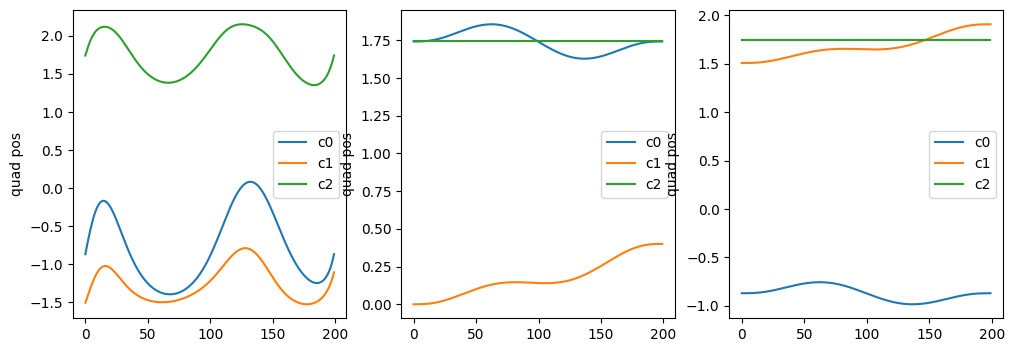

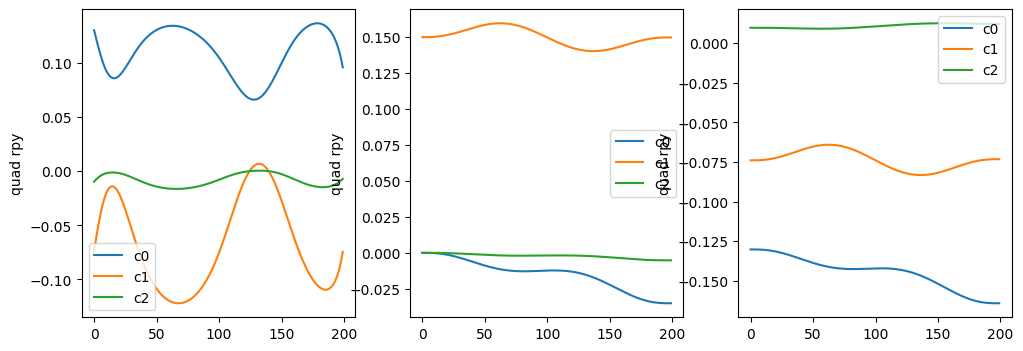

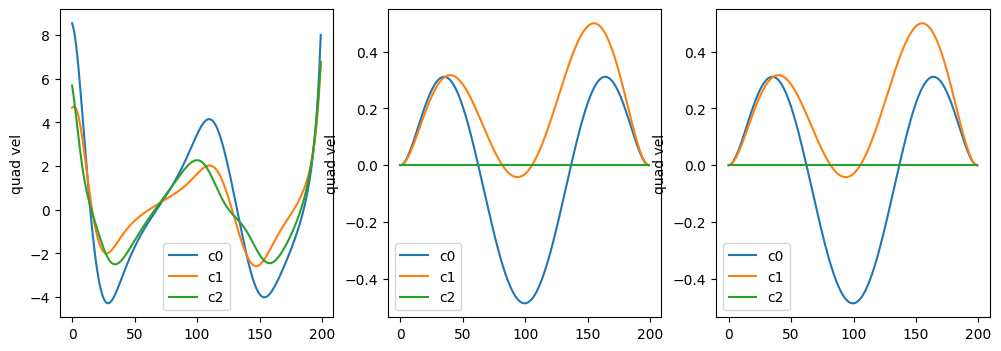

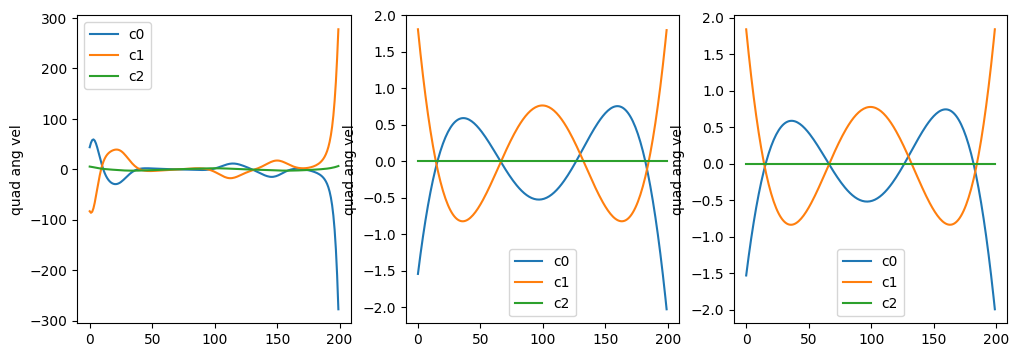

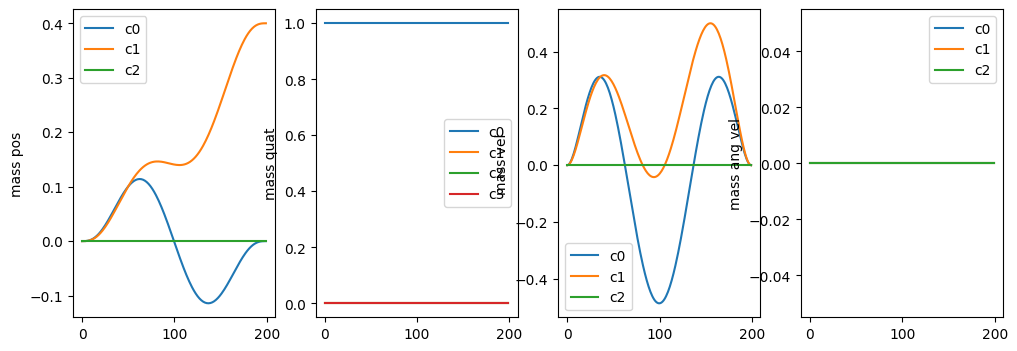

In [41]:
# compute state output traj + controls from flat output variables
quad_all_pos_traj, quad_all_rpy_traj, quad_all_vel_traj, quad_all_omega_traj, \
    quad_all_us_traj, mass_pos_traj, mass_vel_traj \
    = diff_flat_output_backer.output_traj_to_state_traj(*output_traj)

mass_quat_traj = np.array([np.array([1.0, 0.0, 0.0, 0.0]) for _ in range(len(quad_all_pos_traj))])
mass_omega_traj = np.array([np.zeros(3) for _ in range(len(quad_all_pos_traj))])
num_steps = len(mass_pos_traj)
# quants to plot
plottables = [quad_all_pos_traj, quad_all_rpy_traj, quad_all_vel_traj, quad_all_omega_traj]
plottables_names = ['quad pos', 'quad rpy', 'quad vel', 'quad ang vel']

for plottable, name in zip(plottables, plottables_names):
    plt.figure(figsize=(12, 4))
    for quad_ix in range(n_quadrotors):
        ax = plt.subplot(1, n_quadrotors, quad_ix + 1)
        plottable = np.array(plottable)
        for component_ix in range(plottable.shape[-1]):
            ax.plot(plottable[:, quad_ix, component_ix], label='c%i' % component_ix)
        ax.legend()
        ax.set_ylabel(name)
    plt.show()

plottables = [mass_pos_traj, mass_quat_traj, mass_vel_traj, mass_omega_traj]
plottables_names = ['mass pos', 'mass quat', 'mass vel', 'mass ang vel']

plt.figure(figsize=(12, 4))
for p_ix, (plottable, name) in enumerate(zip(plottables, plottables_names)):
    ax = plt.subplot(1, len(plottables), p_ix + 1)
    plottable = np.array(plottable)
    for component_ix in range(plottable.shape[-1]):
        ax.plot(plottable[:, component_ix], label='c%i' % component_ix)
    ax.legend()
    ax.set_ylabel(name)
plt.show()


In [42]:
state_traj_points = []
control_traj_points = []
for i in range(len(quad_all_pos_traj)):
    state_point = []
    for j in range(n_quadrotors):
        state_point += list(quad_all_pos_traj[i][j])
        state_point += list(quad_all_rpy_traj[i][j])
    state_point += list(mass_quat_traj[i])
    state_point += list(mass_pos_traj[i])
    for j in range(n_quadrotors):
        state_point += list(quad_all_vel_traj[i][j])
        state_point += list(quad_all_omega_traj[i][j])
    state_point += list(mass_omega_traj[i])
    state_point += list(mass_vel_traj[i])

    control_point = []
    for j in range(n_quadrotors):
        control_point += list(quad_all_us_traj[i][j])

    state_traj_points.append(state_point)
    control_traj_points.append(control_point)

state_traj_points = np.array(state_traj_points)
control_traj_points = np.array(control_traj_points)

breaks = np.linspace(0, 1, num_steps)
state_traj = PiecewisePolynomial.FirstOrderHold(breaks, state_traj_points.T)
input_traj = PiecewisePolynomial.FirstOrderHold(breaks, control_traj_points.T)

In [43]:
Q_quadrotor_pos = [10.] * 6
Q_quadrotor_vel = [1.] * 6
Q_freebody_pos = [1.] * 4 + [10.] * 3
Q_freebody_vel = [1.] * 3 + [1.] * 3
Q_pos = Q_quadrotor_pos * n_quadrotors + Q_freebody_pos
Q_vel = Q_quadrotor_vel * n_quadrotors + Q_freebody_vel
Q = np.diag(Q_pos + Q_vel)
R = np.eye(4 * n_quadrotors)

lqr_controller = finite_horizon_lqr_stabilize_to_trajectory(diagram, state_traj, input_traj, Q, R)

In [44]:
controlled_diagram, controlled_plant = add_controller_to_system(diagram, lqr_controller, limit=quadrotor_input_limit)

In [45]:
# Simulate the LQR controller

simulator = Simulator(controlled_diagram)
simulator.set_publish_every_time_step(True)
simulator.set_target_realtime_rate(1.0)
context = simulator.get_mutable_context()

sg = diagram.GetSubsystemByName("scene_graph")
DisableCollisionChecking(sg, context)

pos_noise = 0  #0.5
orien_noise = 0  #0.25
vel_noise = 0  #0.1

vel_mask = np.array(
    [False] * (6 * n_quadrotors + 7) +
    [True] * (6 * n_quadrotors + 6)
)
pos_mask = np.array(
    ([True] * 3 + [False] * 3) * n_quadrotors +
    [False] * 4 + [True] * 3 +
    ([True] * 3 + [False] * 3) * n_quadrotors +
    [False] * 3 + [True] * 3
)
orien_mask = np.logical_not(pos_mask)

pos_mask = np.logical_and(pos_mask, np.logical_not(vel_mask))
orien_mask = np.logical_and(orien_mask, np.logical_not(vel_mask))

# Simulate
while True:
    init = state_traj_points[0].copy()
    init[pos_mask] += np.random.normal(loc=0, scale=pos_noise, size=init[pos_mask].shape)
    init[orien_mask] += np.random.normal(loc=0, scale=orien_noise, size=init[orien_mask].shape)
    init[vel_mask] += np.random.normal(loc=0, scale=vel_noise, size=init[vel_mask].shape)
    context.SetTime(0.0)
    context.SetContinuousState(
        init
    )
    simulator.Initialize()
    simulator.AdvanceTo(controller_time_horizon)
    print(simulator.get_actual_realtime_rate())

RuntimeError: An internal mass matrix associated with the joint that connects body z to body rz is not positive-definite. Since the joint allows rotation, ensure body rz (combined with other outboard bodies) has reasonable non-zero moments of inertia about the joint rotation axes.